# Support Vector Machines (SVM)

## Airbnb Dataset

Este notebook consiste en realizar un ejercicio de **clasificación** y otro de **regresión**, utilizando el *dataset de Airbnb del repositorio*, el cuál contenía un conjunto de alquileres vacacionales ofrecidos en la plataforma AirBnB.

En ambos ejercicios, utilizaremos **Support Vector Machines (SVM)**, de forma que para el ejercicio de clasificación crearemos modelos de **LinearSVC** y **SVC con kernel RBF** y en el ejercicio de regresión se utilizará **LinearSVR** y **SVR con kernel RBF**. Para el primer caso deberemos clasificar nuestro dataset a partir de la variable ```room_type``` y para el segundo usaremos como variable dependiente ```price```.

Además, deberemos afinar los hiperparámetros de cada modelo y explicar en cada caso como hemos realizado este proceso.

In [1]:
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt

# Colocamos la semilla a 42 para que
# los resultados de este notebook sean 
# los mismos en todo momento
np.random.seed(42)

Comenzamos cargando el *dataset* en una variable ```Pandas.DataFrame```, antes de pasar a realizar la manipulación de datos correspondiente en cada uno de los ejercicios.

In [2]:
airbnb_df = pd.read_csv('./airbnb.csv')

## Clasificación

### Estudio estadístico y limpieza de datos

Para el **estudio estadístico y limpieza de datos** de esta parte de clasificación, vamos a realizar las siguientes acciones:


* Eliminaremos **neighbourhood** y **neighbourhood_group** para quedarnos con **latitude** y **longitude**. Esto se debe a que ambos pares de características representan datos similares, ya que un par representa la situación de la vivienda por barrios y el otro par la localización exacta; además, debido a que **neighbourhood** y **neighbourhood_group** son variables categóricas, para tratarlas, normalmente se utiliza el **OneHotEncoder**, que aumenta considerablemente el número de características. Por ello, reduciremos el número de características, lo que suele traducirse en mejores resultados.


* Eliminamos la variable **reviews_per_month**, ya que esta variable y **number_of_reviews** poseen una gran correlación, lo que nos permite eliminar una de las dos y así reducir el número de características de nuestro **dataset**. En las siguientes celdas se mostrará un gráfico con la correlación de ambas variables.


* Escalaremos los datos con **StandardScaler**. Esto se debe a que tal y cómo se comenta en la bibliografía de esta asignatura (capítulo 10 de *Hands-on Machine Learning with Scikit-Learn, Keras and TensorFlow 2nd Edition*), este modelo funciona mejor cuando las características han sido escaladas (restamos su media).


* Dividiremos los datos en un conjunto de **entrenamiento** y **test** en un 80% y un 20% respectivamente.


* Por último, tal y como hicimos en la primera actividad, colocaremos el hiperparámetro ```class_weights='balanced'``` ya que las clases de este *dataset* están desbalanceadas y poseemos muchas menos instancias en una de ellas:

```
Entire home/apt    7926
Private room       5203
Shared room         192
```

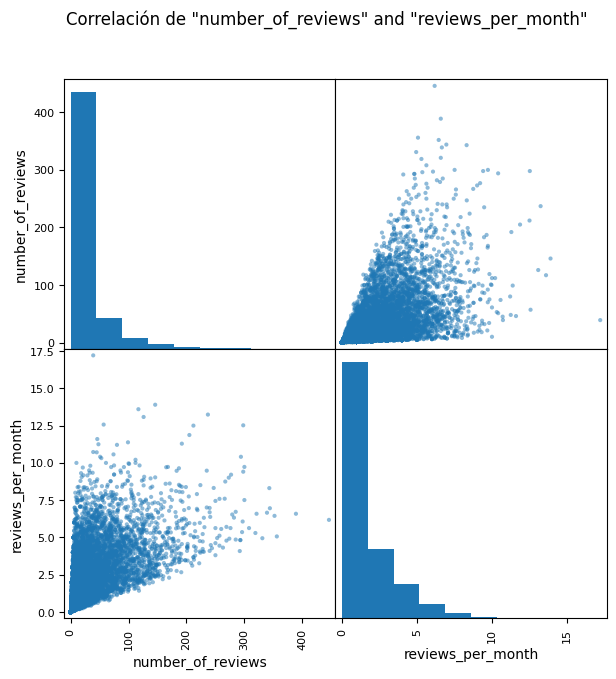

In [3]:
from pandas.plotting import scatter_matrix

scatter_matrix(airbnb_df[['number_of_reviews', 'reviews_per_month']], figsize=(7,7))
plt.suptitle('Correlación de "number_of_reviews" and "reviews_per_month"');

A continuación, realizaremos las modificaciones en el *dataset* que hemos mencionado anteriormente. Eliminaremos las columnas mencionadas a través de la función ```drop``` y crearemos un ```Pipeline``` para escalar las variables numéricas. Finalmente, a través de ```train_test_split```, dividiremos los datos en: **conjunto de entrenamiento y de test** a 80% y 20% respectivamente. 

In [4]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# Eliminamos las columnas mencionadas anteriormente
airbnb_clf = airbnb_df.drop(['neighbourhood', 
                 'neighbourhood_group', 
                 'reviews_per_month'], axis=1)

# Separamos room_type para poder escalar los datos
y_clf = airbnb_clf['room_type']
X_clf = airbnb_clf.drop('room_type', axis=1)

# Creamos el pipeline para escalar los datos
clf_pipeline = Pipeline([('std_scaler', StandardScaler())])

# Utilizamos el pipeline para escalar los datos
X_clf = clf_pipeline.fit_transform(X_clf)

# Y obtenemos un DataFrame con los datos ya transformados
airbnb_clf = pd.DataFrame(X_clf, columns=clf_pipeline.get_feature_names_out())

# Finalmente, dividimos los datos en el conjunto de entrenamiento y de test
X_clf_train, X_clf_test, y_clf_train, y_clf_test = train_test_split(X_clf, y_clf, test_size=0.2, random_state=42)

### Ejecución de los modelos

Una vez que tenemos los datos preparados, pasaremos a crear y ejecutar los modelos. Tal y como se indica en el enunciado de esta actividad, deberemos dividir el conjunto de entrenamiento y el de test, de forma que el segundo suponga un 20% (ya realizado en el anterior paso), y además se deberá evaluar los modelos usando **cross_validation** con **accuracy** y **10 pliegues**. Una vez hecho esto, tendremos que comparar los resultados de los modelos.


Para llevar a cabo una evaluación correcta, definiremos la función ```evaluar```, la cuál nos permitirá evaluar tanto los modelos de **clasificación** como de **regresión** con las especificaciones que nos indica el enunciado. Cabe mencionar que para **regresión** usaremos **R2** como score.

In [5]:
from sklearn.model_selection import cross_val_score

# Funcion Auxiliar para evaluar nuestros modelos
def evaluar(modelo, X, y, classification):
    """
    Función que devuelve un análisis de la evaluación de un modelo
    
    Params:
        modelo: el modelo clasificatorio que utilizaremos
        
        X: el conjunto de características de cada individuo
        
        y: el conjunto de etiquetas (labels) de cada individuo
        
        classification: booleano que nos permite indicar si el modelo
                        es un clasificador o una regresion
        
    Return:
        analysis: una cadena conteniendo la información obtenida del análisis
    """    
    
    if(classification):
        scores = cross_val_score(modelo, X, y, scoring='accuracy', cv=10)

        analysis = f'Nuestro modelo devuelve la siguiente puntuación en cada validación:\n\n {scores} \n\nSiendo el mínimo valor: {np.min(scores):.3f}\nEl máximo: {np.max(scores):.3f}\nY una media de: {np.mean(scores): .3f}.\n'
    
    else:
        scores = cross_val_score(modelo, X, y, scoring='r2', cv=10)
        
        analysis = f'Nuestro modelo devuelve la siguiente puntuación en cada validación:\n\n {scores} \n\nSiendo el mínimo valor: {np.min(scores):.3f}\nEl máximo: {np.max(scores):.3f}\nY una media de: {np.mean(scores): .3f}.\n'

    return analysis

### Linear SVC

Pasaremos primero a ejecutar el modelo de **LinearSVC**. Como indica la guía de esta actividad, dejaremos sus hiperparámetros por defecto. Sin embargo, hay 3 que hemos modificado por distintas razones:


* ```random_state``` a 42. Con esto, haremos que cada ejecución, el modelo devuelva los mismos resultados y podamos analizarlos debidamente.


* ```class_weight```en ```balanced```, porque como ya hemos mencionado anteriormente, las clases están desbalanceadas y así podremos obtener unos resultados más fiables.


* ```loss='hinge'``` ya que tal y como indica la bibliografía, esta función de pérdida será la más óptima cuando escalemos nuestros datos.

In [6]:
from sklearn.svm import LinearSVC

# Linear SVC
linear_svc = LinearSVC(class_weight='balanced',
                    loss='hinge', 
                    random_state=42)

# Entrenamos con el conjunto de entrenamiento
linear_svc.fit(X_clf_train, y_clf_train)

C:\Users\Rafa\anaconda3\envs\mt_python\Lib\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
C:\Users\Rafa\anaconda3\envs\mt_python\Lib\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


LinearSVC(class_weight='balanced', loss='hinge', random_state=42)

Una vez que hemos creado el modelo, pasamos a ejecutar la función ```evaluar``` para obtener la puntuación de nuestro modelo sobre el conjunto de test.

In [7]:
print(evaluar(linear_svc, X_clf_test, y_clf_test, True))

C:\Users\Rafa\anaconda3\envs\mt_python\Lib\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
C:\Users\Rafa\anaconda3\envs\mt_python\Lib\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Rafa\anaconda3\envs\mt_python\Lib\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
C:\Users\Rafa\anaconda3\envs\mt_python\Lib\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Rafa\anaconda3\envs\mt_python\Lib\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` wi

Nuestro modelo devuelve la siguiente puntuación en cada validación:

 [0.84269663 0.83895131 0.88389513 0.82397004 0.83895131 0.85714286
 0.84586466 0.86466165 0.86466165 0.85338346] 

Siendo el mínimo valor: 0.824
El máximo: 0.884
Y una media de:  0.851.



C:\Users\Rafa\anaconda3\envs\mt_python\Lib\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Rafa\anaconda3\envs\mt_python\Lib\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
C:\Users\Rafa\anaconda3\envs\mt_python\Lib\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Rafa\anaconda3\envs\mt_python\Lib\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
C:\Users\Rafa\anaconda3\envs\mt_python\Lib\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to conver

Obtenemos una **precisión media del 85.1%**, lo cuál es una puntuación muy alta para ser una ejecución con los hiperparámetros por defecto.

### SVC

A continuación, pasamos a crear nuestro modelo de **SVC**, el cuál tendrá también la semilla colocada a 42 y con la opción activada para arreglar el desbalanceo de clases. Cabe mencionar que el kernel por defecto ya es **RBF**, el que se pide usar en esta actividad, por eso lo hemos omitido en el constructor del modelo.

In [8]:
from sklearn.svm import SVC

# Polynomial Kernel SVC
svc = SVC(class_weight='balanced',
                   random_state=42)

# Entrenamos con el conjunto de entrenamiento
svc.fit(X_clf_train, y_clf_train)

SVC(class_weight='balanced', random_state=42)

Por último, ejecutamos la función ```evaluar``` y obtenemos:

In [9]:
print(evaluar(svc, X_clf_test, y_clf_test, True))

Nuestro modelo devuelve la siguiente puntuación en cada validación:

 [0.76779026 0.70786517 0.75655431 0.73033708 0.76404494 0.7518797
 0.7593985  0.7593985  0.79323308 0.77443609] 

Siendo el mínimo valor: 0.708
El máximo: 0.793
Y una media de:  0.756.



En este caso, obtenemos una puntuación menor a la del **LinearSVC**, con una **precisión del 75.6%**. Más adelante posiblemente esta puntuación mejore una vez que afinemos los hiperparámetros.

### Comparación

Antes de realizar la afinación de hiperparámetros, pasaremos a comparar los resultados obtenidos en la primera ejecución que hemos realizado.

En cuanto a la puntuación obtenida por ambos modelos, podemos observar que **LinearSVC** ha obtenido mayor puntuación que **SVC**. Teniendo el primero un **85.1%** de media en precisión y el segundo un **75.6%**. Esto se debe a que el **SVC** tiene 2 hiperparámetros fundamentales para un funcionamiento óptimo: ```gamma``` y ```C``` y podremos esperar mejores resultados cuando afinemos ambos. 

Ahora, pasaremos a crear y visualizar la matriz de confusión para ver como ha clasificado cada modelo cada una de las clases.

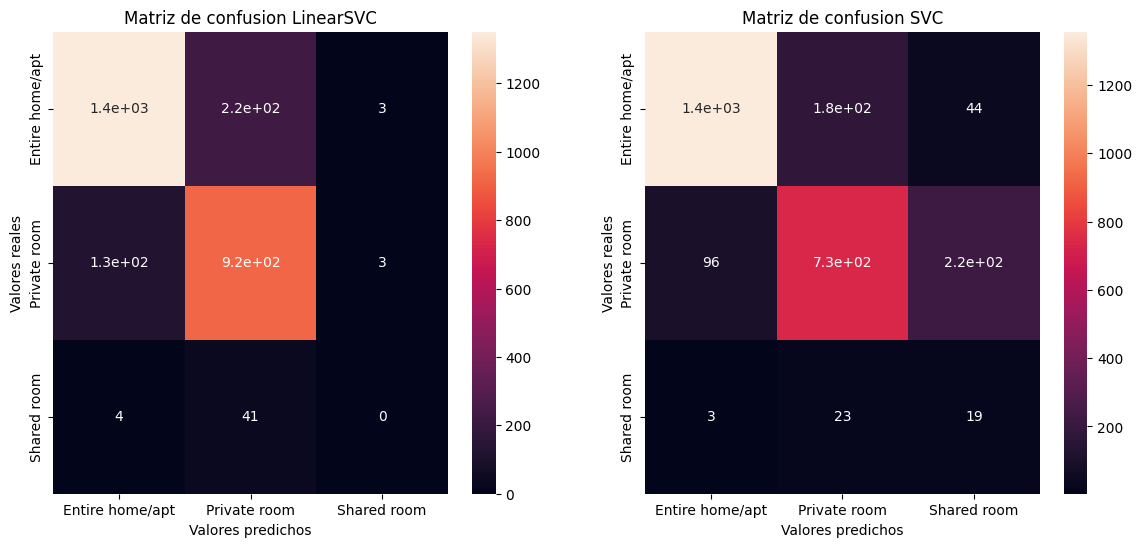

In [10]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14,6))

# LinearSVC
# Predicción
y_prediction = linear_svc.predict(X_clf_test)

# Creamos la matriz de confusión
lin_svc_mat = confusion_matrix(y_clf_test, y_prediction)

# Visualizamos la matriz de confusión
sns.heatmap(lin_svc_mat, annot=True, ax=axes[0])
axes[0].title.set_text('Matriz de confusion LinearSVC')
axes[0].set(ylabel="Valores reales")
axes[0].set(xlabel="Valores predichos")
axes[0].xaxis.set_ticklabels(['Entire home/apt', 'Private room', 'Shared room']); 
axes[0].yaxis.set_ticklabels(['Entire home/apt', 'Private room', 'Shared room']);

# SVC
# Predicción
y_prediction = svc.predict(X_clf_test)

# Creamos la matriz de confusión
svc_mat = confusion_matrix(y_clf_test, y_prediction)

# Visualizamos la matriz de confusión
sns.heatmap(svc_mat, annot=True, ax=axes[1])
axes[1].title.set_text('Matriz de confusion SVC')
axes[1].set(ylabel="Valores reales")
axes[1].set(xlabel="Valores predichos")
axes[1].xaxis.set_ticklabels(['Entire home/apt', 'Private room', 'Shared room']); 
axes[1].yaxis.set_ticklabels(['Entire home/apt', 'Private room', 'Shared room']);


plt.show();

Como podemos observar, ambos modelos clasifican de manera muy óptima la clase ```Entire home/apt``` y de manera bastante buena también ```Private room```. Sin embargo, podemos notar que ninguno de los dos modelos clasifica bien ```Shared room```. Esto, como hemos comentado anteriormente, se debe al **desbalanceo de las clases**; como podemos observar en la siguiente celda, el número de datos que poseemos de ```Shared room``` es casi 10 veces menos que el de ```Entire home/apt```, por lo que nuestro modelo no tendrá buenos resultados a la hora de intentar clasificar estas instancias. Para intentar subsanar esta situación colocamos el hiperparámetro ```class_weights='balanced'``` pero como podemos observar, ante tan poca cantidad de datos, sigue siendo difícil clasificar ```Shared room```. 


Además, visualizamos que **LinearSVC** apenas marca una clase como ```Shared room```; de hecho, el gráfico nos muestra que no ha acertado en clasificar a esta ni una sola vez, y si nos fijamos, toda la fila de valor real ```Shared room``` está prácticamente vacía (color negro) al igual que la columna de valor predicho ```Shared room```. Es decir, **LinearSVC** no clasifica correctamente a esta clase y se centra en las dos otras, de las que sí posee una gran cantidad de datos. Por otro lado, respecto a esto, **SVC** sí que al menos "hace el intento" de clasificarla. Si nos fijamos, ha acertado 19 instancias de esta clase e incluso a veces en un gran número de ocasiones, confunde ```Private room``` con ```Shared room```, sin embargo, clasifica más veces acertadas al primero.


Por tanto, podemos decir que los modelos clasifican las clases a un nivel aceptable, a excepción de ```Shared room```, de la que, a pesar de colocar el hiperparámetro ```class_weights='balanced'```, no conseguimos categorizarla correctamente.

In [11]:
airbnb_df['room_type'].value_counts()

room_type
Entire home/apt    7926
Private room       5203
Shared room         192
Name: count, dtype: int64

### Afinación de hiperparámetros

Para afinar los hiperparámetros ```gamma``` y ```C``` de **SVC**, deberemos utilizar la función **GridSearchCV**, que se encarga de tomar una variable diccionario con los parámetros a comprobar y nos devuelve los resultados de cada uno de ellos, de forma que elijamos el que mejor se comporta ante los datos. Además, esta función tiene la posibilidad de indicarle los **pliegues** (*validación cruzada*) en los que queremos que se subdivida nuestros datos para comprobar que el modelo funciona bien en la mayoría del conjunto.


En las primera pruebas, hemos detectado que este modelo junto con **GridSearchCV** puede conllevar una gran carga computacional, lo que se traduce en muchísimo tiempo de ejecución. Por ello, tal y como se indica en enunciado de la actividad, realizaremos varias búsquedas espaciadas logarítmicamente (usando ```numpy.logspace```) para ir acotando una zona óptima de búsqueda y así evitar recorrer un gran espacio numérico para llegar a la mejor combinación de hiperparámetros.


Por tanto, hemos realizado **3 búsquedas en total**: 2 logarítmicas y una equispaciada (```numpy.linspace```). Esto lo hemos decidio así porque queríamos acotar grandes rangos con cada ejecución logarítmicas y finalmente, con un menor número de datos, saber qué valor es el óptimo dentro de ese pequeño conjunto final. Además, para evitar mayor tiempo de ejecución, hemos ido aumentando el número de **pliegues** en cada búsqueda, de forma que con cada ejecución teníamos un rango de valores que actuaban mejor.

Pasamos ahora a explicar las búsquedas realizadas:

* **1ª búsqueda:** 
    * 15 valores en el espacio de ambos parámetros (```np.logspace(num=15, ...)```) 
    * CV=2 (pliegues) 
    * Rango de C desde 2<sup>-5</sup> hasta 2<sup>10</sup>
    * Rango de Gamma desde 2<sup>-10</sup> hasta 2<sup>5</sup>
    
Esta búsqueda tardó **14.7 minutos** y nos devolvió que el mejor resultado era ```{'C': 24.982693828982715, 'gamma': 0.8619728212469772}``` con una **precisión del 85.32%**. Sólo en esta primera ejecución, que apenas ha durado 15 minutos, hemos conseguido aumentar bastante la precisión del modelo.


Por tanto, ahora, siguiendo el método descrito en *A practical guide to Support Vector Machines* realizaremos otra búsqueda acotando los valores alrededor del mejor valor obtenido anteriormente.


* **2ª búsqueda:** 
    * 15 valores de en el espacio de ambos parámetros (```np.logspace(num=15, ...)```) 
    * CV=5 (pliegues) 
    * Rango de C desde 2<sup>3</sup> hasta 2<sup>8</sup>
    * Rango de Gamma desde 2<sup>-3</sup> hasta 2<sup>2</sup>
    
Esta búsqueda se llevó a cabo en **47 minutos** y el mejor resultado fue ```{'C': 35.330864437561985, 'gamma': 0.9057236642639067}``` con una **precisión del 85.96%**.

Como podemos ver, de nuevo, la precisión ha aumentado y como en esta ocasión hemos colocado **5 pliegues**, la ejecución ha llevado 47 minutos.

Por último, una vez que hemos acotado bastante los resultados, pasaremos a realizar una última búsqueda lineal con **10 pliegues** y pocos valores a comprobar.

* **3ª búsqueda:** 
    * 8 valores de en el espacio de ambos parámetros (```np.linspace(num=15, ...)```) 
    * CV=10 (pliegues) 
    * Rango de C desde 2<sup>5</sup> hasta 2<sup>5.75</sup>
    * Rango de Gamma desde 2<sup>-0.25</sup> hasta 2<sup>0.5</sup>
    
Esta búsqueda se completó en **49.5 minutos** y el mejor resultado fue ```{'C': 47.58383612588409, 'gamma': 0.8408964152537145}```, con un **86.45% de precisión.**

Como podemos comprobar, a pesar de ser la búsqueda con menos valores a comprobar (8x8 = 64), debido a haber aumentado el número de **pliegues** también aumenta exponencialmente el tiempo de ejecución.

En conclusión, mediante este método hemos ido acotando los valores del rango que propusimos inicialmente, sin que la ejecución de las 3 búsquedas llegue las 2 horas y obteniendo una precisión del **86.45%**, en comparación con la incial que suponía un **75.6%**, más de un 10%.



Por último, vamos a adjuntar el código que hemos usado para las búsquedas:

```python
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import OrdinalEncoder
from sklearn.svm import SVC
import numpy as np
import time


# Definimos el rango de valores a comprobar
C_range = np.linspace(start=pow(2,5), stop=pow(2,5.75), num=8)
G_range = np.linspace(start=pow(2,-0.25), stop=pow(2,0.5), num=8)

# Creamos el modelo
svc = SVC(class_weight='balanced', random_state=42)

# Definimos el diccionario para GridSearchCV
param_grid = [
    {'gamma':G_range, 
     'C': C_range
    }
]

# Creamos la variable GridSearchCV
grid_search_clf = GridSearchCV(svc, param_grid, cv=10, scoring='accuracy',  
                           return_train_score=True, n_jobs=-1)


# Transformamos "y" en una variable numerica  a traves de ordinalencoder
ord_encoder = OrdinalEncoder()
y_ord = ord_encoder.fit_transform(y_clf_train.values.reshape(-1,1)).ravel()

inicio = time.time() # Comienza cronometro

# Comenzamos ls busqueda
grid_search_clf.fit(X_clf_train, y=y_ord)

fin = time.time() # Termina cronometro


print(f'El tiempo de ejecución ha sido: {fin-inicio}') # 1.0005340576171875
print(f'El mejor resultado es: {grid_search_clf.best_params_}')

# Aqui imprimimos todos los modelos explorados con su resultado
cvres= grid_search_clf.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(mean_score, params)
```

## Regresión

### Estudio estadístico y limpieza de datos

Para el **estudio estadístico y limpieza** de datos de la parte de regresión, tenemos que modificar el *dataset* de forma muy distinta a la realizada en el ejercicio anterior, ya que se pide cumplir una serie de requisitos distintos a los propuestos para la parte de clasificación.

El enunciado, para esta parte del preprocesado de datos, nos indica que deberemos usar ```price``` (precio por noche) como **variable dependiente**, y el resto de características de nuestros datos, como **variables independientes**; a diferencia del ejercicio de clasificación, donde usamos ```room_type```.


Además, tendremos que estudiar estadísticamente ```price```, ```minimum_nights``` y ```calculated_host_listings``` para eliminar *outliers* (datos aislados) convenientes. Para esto, en la siguiente celda, realizaremos un **gráfico de caja** (*box plot*) donde  a la izquierda mostraremos como se agrupan los datos sin ningún filtro, y a la derecha, eliminando un cierto percentil para evitar *outliers*.

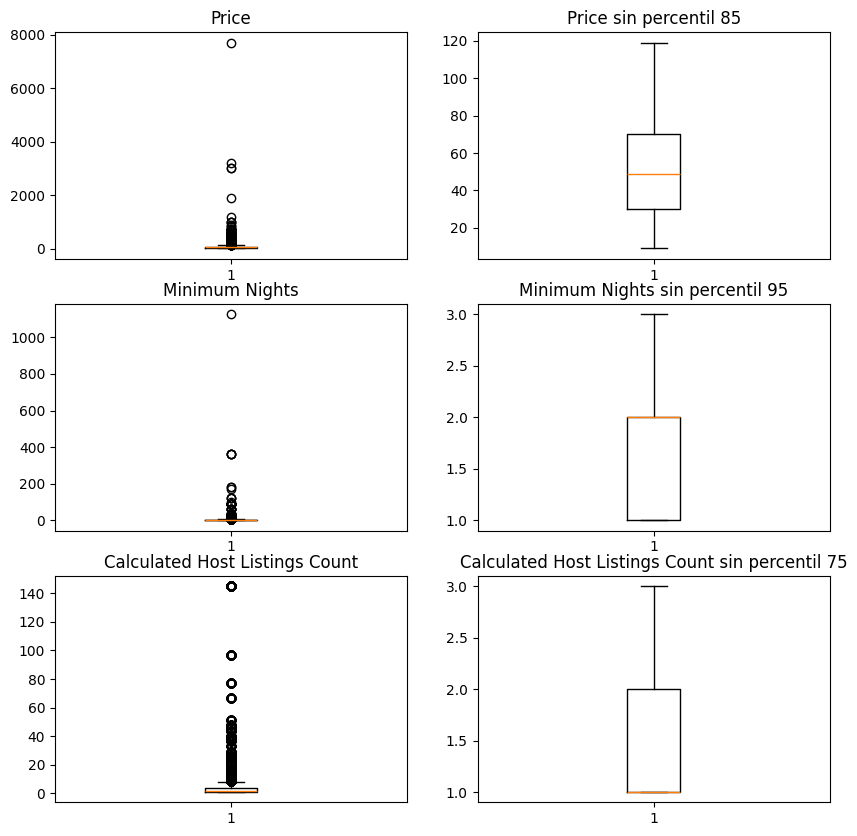

In [12]:
# Creamos el subplot de 3x2
figs, axs = plt.subplots(3, 2, figsize=(10, 10))

# Price
axs[0, 0].boxplot(airbnb_df.price) 
axs[0, 0].set_title('Price')

# Price sin percentil 85
axs[0, 1].boxplot(airbnb_df[airbnb_df.price < airbnb_df.price.quantile(0.9)].price) 
axs[0, 1].set_title('Price sin percentil 85')

# Minimum Nights
axs[1, 0].boxplot(airbnb_df.minimum_nights)
axs[1, 0].set_title('Minimum Nights')

# Minimum Nights sin percentil 90
axs[1, 1].boxplot(airbnb_df[airbnb_df.minimum_nights < airbnb_df.minimum_nights.quantile(0.9)].minimum_nights)
axs[1, 1].set_title('Minimum Nights sin percentil 95');

# Calculated Host Listings Count
axs[2, 0].boxplot(airbnb_df.calculated_host_listings_count)
axs[2, 0].set_title('Calculated Host Listings Count')

# Calculated Host Listings Count sin percentil
axs[2, 1].boxplot(airbnb_df[airbnb_df.calculated_host_listings_count < airbnb_df.calculated_host_listings_count.quantile(0.75)].calculated_host_listings_count)
axs[2, 1].set_title('Calculated Host Listings Count sin percentil 75');

Como podemos observar en las 3 variables (columna de la izquierda), la gran mayoría de los datos se agrupan en una zona, sin embargo, justo encima se muestran otros muchos datos que están muy lejos de esa zona y que podemos considerar *outliers*. 


Analizando uno a uno, podemos ver que la variable **price** posee su mediana en 50€ aproximadamente y que el 75% de sus datos se encuentran por debajo de los 65€ (aprox.) por noche. Por eso, datos como los 7000€/noche que vemos en el gráfico sin filtro, no tienen mucho sentido a la hora de alimentarlo a nuestro modelo, ya que es un dato muy aislado y desorbitado a la hora de hablar de alquileres por una sola noche. Por ello, hemos considerado que eliminando el **percentil 85**, nuestros datos tienen una muy buena distribución, encontrándose el 85% de datos en una zona entre 0€ y 100€ por noche.


Si observamos ahora la variable **minimum_nights**, podemos ver la misma situación que antes, la mayoría de datos se agrupan en una zona muy concentrada. Por ello, hemos decidido eliminar los datos por debajo del **percentil 95**. Puede parecer increíble que simplemente eliminando el 5% de los datos hayamos eliminado prácticamente todos los outliers de esta variable, pero esto se debe a que la variable representa el mínimo número de noches que un cliente debe alquilar la vivienda; normalmente, los alquileres en esta aplicación tienen un mínimo de 1 noche, ya que AirBnB está orientada a turistas o personas que pasen poco tiempo en un lugar; por lo que si nos fijamos en los datos ya filtrados, podemos observar que el 75% de estos se encuentran entre 3 y 1 noche y la mediana en 2.


Por último, de igual forma que ha ocurrido en las 2 variables anteriores, sucede con **calculated_host_listings**. Esta variable indica el número de anuncios activos simultáneos que tiene el anfitrión. Para eliminar los *outliers*, hemos decidido eliminar los datos por debajo del **percentil 75%**, de forma que el 75% de los datos estarán por debajo de los 2 alquileres activos, el 25% en 1 alquiler y la mediana también en 1 alquiler.

Una vez que hemos eliminado *outliers*, deberemos comprobar cómo actúan nuestros modelos ante las variables ```neighbourhood``` y ```neighbourhood_group```. Estas variables son categóricas, por lo que deberemos codificarlas mediante algún método, como ```OneHotEncoder```, si queremos ofrecérselas a nuestros modelos. Sin embargo, ```OneotEncoder``` a pesar de ser el método que mejor codifica estas variables (```OrdinalEncoder``` coloca un orden inherente en los datos que preferimos evitar), también aumenta considerablemente el número de características en nuestros datos. Por ello, pasaremos a comprobar cómo actúan mejor los modelos.

Los resultados obtenidos (la puntuación de los modelos de regresión será **R2**) para la ejecución del **LinearSVR** SIN las variables ```neighbourhood``` y ```neighbourhood_group``` son los siguientes:

```

Nuestro modelo devuelve la siguiente puntuación en cada validación:

 [0.38710823 0.47090862 0.51917583 0.61033075 0.49588424 0.59380012
 0.52375619 0.55556057 0.47125632 0.48450823] 

Siendo el mínimo valor: 0.387
El máximo: 0.610
Y una media de:  0.511.
```


Y para **SVR**:

```
Nuestro modelo devuelve la siguiente puntuación en cada validación:

 [0.43995356 0.42374243 0.55723089 0.54695875 0.52906746 0.61089254
 0.56253991 0.5589123  0.4667091  0.53495463] 

Siendo el mínimo valor: 0.424
El máximo: 0.611
Y una media de:  0.523.
```

Sin embargo, como veremos más en detalle a continuación, con ambas variables codificadas a través de **OneHotEncoder**, **LinearSVR** obtiene una precisión media de **55.8%** y **SVR** un **55.4%**.

De igual manera, mantendremos la variable ```reviews_per_month``` (la cuál eliminamos en la clasificación) ya que devuelve mejores resultados. Eliminando la variable obtenemos para **LinearSVR** un 56.3% y para **SVR** un 54.8%, que es un valor menor que lo obtenido manteniéndola. 


Cabe mencionar que en esta ocasión también escalaremos los datos con ```StandardScaler```, al igual que hicimos con los modelos en la clasificación, para obtener mejores datos.



Finalmente, realizaremos las acciones indicadas anteriormente sobre los datos. Primero crearemos un ```ColumnTransformer``` (se puede ejecutar varios pipelines para distintas columnas) para codificar las variables categóricas (```room_type, neighbourhood_group y neighbourhood```) y escalar las numéricas.

In [13]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder

# Pipeline creado para normalizar las variables numéricas y codificar las variables categoricas
cat_features = ['room_type', 'neighbourhood_group', 'neighbourhood']
num_features = list(airbnb_df.drop(cat_features, axis=1))

# Creamos el pipeline para las variables numéricas.
# Escalaremos los datos 
num_pipeline = Pipeline([('std_scaler', StandardScaler())])

# Creamos el pipeline para las variables categóricas
# usando OneHotEncoder
cat_pipeline = Pipeline([('cat_encoder', OneHotEncoder())])

# Finalmente tendremos nuestro pipeline completo
reg_pipeline = ColumnTransformer(
remainder='passthrough',
transformers=[("num", num_pipeline, num_features),
("cat", cat_pipeline, cat_features)])

Y a continuación, pasaremos a realizar las modificaciones mencionadas sobre el *dataset*. 

In [14]:
# Eliminamos outliers en price, minimum_nights y
# calculated_host_listings_count
airbnb_reg = airbnb_df[(airbnb_df.price < airbnb_df.price.quantile(0.85)) &
                       (airbnb_df.minimum_nights < airbnb_df.minimum_nights.quantile(0.95)) &
                       (airbnb_df.calculated_host_listings_count < airbnb_df.calculated_host_listings_count.quantile(0.75))]

# Utilizamos el pipeline para escalar los datos
airbnb_reg = reg_pipeline.fit_transform(airbnb_reg)

# Obtenemos un DataFrame con los datos ya transformados
airbnb_reg = pd.DataFrame(airbnb_reg.toarray(), columns=reg_pipeline.get_feature_names_out())

# Separamos las variables independientes y dependiente
y_reg = airbnb_reg['num__price']
X_reg = airbnb_reg.drop(['num__price'], axis=1)

# Finalmente, dividimos los datos en el conjunto de entrenamiento 
# y de test
X_reg_train, X_reg_test, y_reg_train, y_reg_test = train_test_split(X_reg, y_reg, test_size=0.2, random_state=42)

### Ejecución de los modelos

### LinearSVR

Para la creación del modelo **LinearSVR**, colocaremos ```random_state``` a 42, para que cada ejecución devuelva el mismo resultado.

In [15]:
from sklearn.svm import LinearSVR

linear_svr = LinearSVR(random_state=42)
linear_svr.fit(X_reg_train, y_reg_train)

C:\Users\Rafa\anaconda3\envs\mt_python\Lib\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
C:\Users\Rafa\anaconda3\envs\mt_python\Lib\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


LinearSVR(random_state=42)

Una vez creado, ejecutamos ```evaluar``` para ver los resultados del modelo.

In [16]:
print(evaluar(linear_svr, X_reg_test, y_reg_test, False))

C:\Users\Rafa\anaconda3\envs\mt_python\Lib\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
C:\Users\Rafa\anaconda3\envs\mt_python\Lib\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Rafa\anaconda3\envs\mt_python\Lib\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
C:\Users\Rafa\anaconda3\envs\mt_python\Lib\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Rafa\anaconda3\envs\mt_python\Lib\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` wi

Nuestro modelo devuelve la siguiente puntuación en cada validación:

 [0.44603652 0.5069727  0.56059257 0.61112962 0.56014253 0.60387252
 0.57796262 0.59759963 0.51757274 0.59373338] 

Siendo el mínimo valor: 0.446
El máximo: 0.611
Y una media de:  0.558.



C:\Users\Rafa\anaconda3\envs\mt_python\Lib\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
C:\Users\Rafa\anaconda3\envs\mt_python\Lib\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


La puntuación que hemos usado es **R2**, la cuál se encuentra entre 0 y 1, siendo 1 un modelo que se ajusta de manera perfecta a los datos. Por tanto, obtenemos en una ejecución con los parámetros por defecto una **puntuación de 0.558**, que es bastante optimista ajustando los datos.

### SVR

Ahora pasaremos a **SVR**, creamos y ejecutamos el modelo:

In [17]:
from sklearn.svm import SVR

svr = SVR()
svr.fit(X_reg_train, y_reg_train)

SVR()

In [18]:
print(evaluar(svr, X_reg_test, y_reg_test, False))

Nuestro modelo devuelve la siguiente puntuación en cada validación:

 [0.44029421 0.46939562 0.61660596 0.56955196 0.57415984 0.62357881
 0.5766458  0.55140107 0.51961743 0.60117514] 

Siendo el mínimo valor: 0.440
El máximo: 0.624
Y una media de:  0.554.



En este caso, obtenemos una puntuación algo menor que con **LinearSVR**, obteniendo un **0.554** en esta ocasión. Por lo que, tal y como indica el enunciado, será el modelo seleccionado para la afinación de hiperparámetros de este ejercicio.

### Comparación

En esta sección, vamos a comparar los resultados obtenidos en ambos modelos de regresión y a visualizarlos a través de algún gráfico.

Primero, hablando de las puntuaciones obtenidas, como hemos podido comprobar, los modelos actúan prácticamente igual, siendo **LinearSVR** ligeramente mejor (0.558 comparado con 0.554). La puntuación, **R<sup>2</sup> score**, es un coeficiente comprendido entre 0 y 1 (aunque puede ser negativo), siendo el 0 un modelo que no sigue la tendencia de los datos y el 1 un modelo que ajusta perfectamente los datos.


Aunque parezca que las puntuaciones obtenidas son bajas, hay que tener en cuenta que un modelo con **R<sup>2</sup> score** alrededor de 0.5 puede llegar a tener buenos resultados, no es necesario obtener un R<sup>2</sup> superior para que el modelo funcione correctamente. Además, para el caso de **LinearSVC**, este se trata de un modelo lineal ante un conjunto de datos que a priori no parece tener una relación lineal entre ```price``` y las variables independientes.

A continuación, vamos a crear una gráfica para mostrar la puntuación del **R<sup>2</sup> score** en cada modelo.

C:\Users\Rafa\anaconda3\envs\mt_python\Lib\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


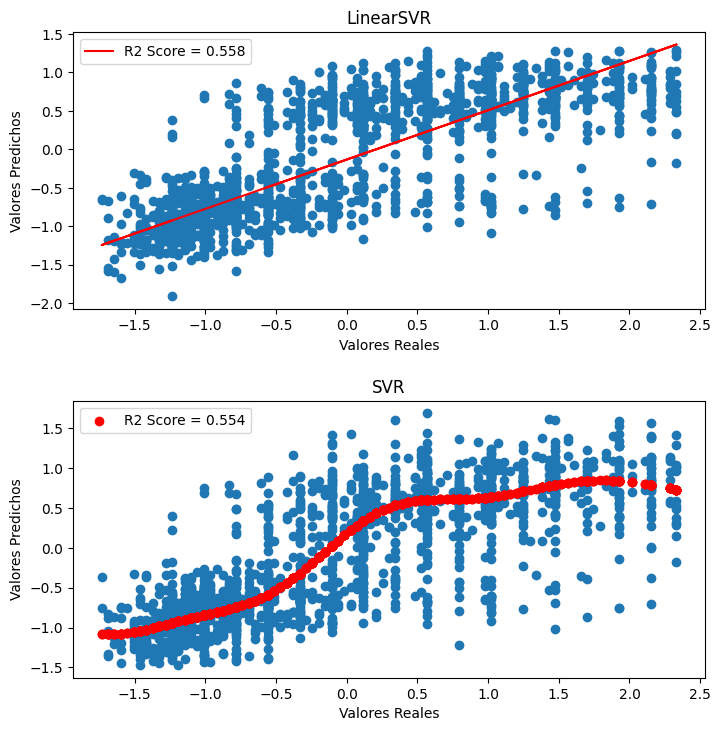

In [19]:
# Creamos una figura para dibujar nuestros gráficos
fig, axes = plt.subplots(2, figsize=(8, 8))
fig.tight_layout(pad=4.5)

# LinearSVR
y_predicted = linear_svr.predict(X_reg_test)

# Dibujamos los valores reales y predichos
axes[0].scatter(y_reg_test.values, y_predicted)

# Dibujamos la linea del R2 score
y_test = y_reg_test.values.reshape(-1,1)
axes[0].plot(y_test, 
             LinearSVR().fit(y_test, y_predicted).predict(y_test),
             color='r',
            label='R2 Score = 0.558')
axes[0].legend()



# Colocamos la etiqueta de los ejes
axes[0].set_xlabel('Valores Reales')
axes[0].set_ylabel('Valores Predichos')
axes[0].set_title('LinearSVR')


# SVR
y_predicted = svr.predict(X_reg_test)

# Dibujamos los valores reales y predichos
axes[1].scatter(y_reg_test.values, y_predicted)

# Dibujamos la linea del R2 score
y_test = y_reg_test.values.reshape(-1,1)
axes[1].scatter(y_test,
             SVR().fit(y_test, y_predicted).predict(y_test),
            color='r',
            label='R2 Score = 0.554')

# Colocamos la etiqueta de los ejes
axes[1].set_xlabel('Valores Reales')
axes[1].set_ylabel('Valores Predichos')
axes[1].title.set_text('SVR')
axes[1].legend()



plt.show()

En la figura de arriba se muestran 2 gráficas con los valores reales y predichos de cada modelo, en el eje X se encuentran los **valores reales** y en el eje Y los **valores predichos**. Si nuestros modelos fueran perfectos (*R<sup>2</sup>=1*), entonces los puntos tendrían que formar una diagonal recta desde el mínimo valor hasta el último, esto significa, que nuestro modelo ha predicho el valor exacto al real. Por otra parte, **la línea roja muestra** cómo se ha ajustado el modelo a los datos (**puntuación R<sup>2</sup>**), de forma que si nuestro modelo fuera perfecto, todas las predicciones (puntos en la gráfica) estarían por debajo de estas líneas.


En el caso de **LinearSVC**, podemos observar que el modelo tiene una pendiente ascendente y por tanto, se ajusta a la nube de puntos de manera más o menos correcta; sin embargo, tanto en la mitad como en parte del final, podemos observar que los datos están muy dispersos y no se ajusta demasiado bien a estos valores.  


En el caso de **SVC**, como es un modelo no lineal, podemos observar que su ajuste sigue una forma curvilínea. Además, tal y como observamos, aunque sigue bien la nube de punto, pasa algo parecido al anterior modelo, las predicciones están demasiado dispersas y por tanto, no se consigue una gran puntuación.

### Afinación de hiperparámetros

Como hemos mencionado antes, debido a que **LinearSVR** ha sido el modelo que mayor puntuación ha obtenido, vamos a pasar a afinar su hiperparámetro C.


Para este caso, hemos seguido la misma metodología que en el ejercicio de clasificación, realizando 3 búsquedas, 2 con rangos logarítmicos y 1 lineal y . Sin embargo, en esta ocasión, el tiempo de ejecución ha caído exponencialmente. Vamos a pasar a mostrar las 3 ejecuciones:

* **1ª búsqueda:** 
    * 100 valores en el espacio del parámetro (```np.logspace(num=100, ...)```) 
    * CV=2 (pliegues) 
    * Rango de C desde 2<sup>-5</sup> hasta 2<sup>10</sup>
    
Esta búsqueda tardó **11.5 segundos** y nos devolvió que el mejor resultado era ```{'C': 1.0}``` con un **R2 del 0.5609**.

Como podemos observar, la ejecución de 100 parámetros tarda 11.5 segundos; esto no solo se debe a que estamos afinando un sólo hiperparámetro, sino a que el modelo a afinar en esta ocasión es **lineal**, el cuál suele ejecutarse en mucho menos tiempo, a diferencia de la clasificación que fue **SVC con kernel RBF**. 

Para la siguiente búsqueda, colocamos el rango alrededor del valor obtenido, con el mismo número de valores y en este caso **5 pliegues** (cv=5).

* **2ª búsqueda:** 
    * 100 valores en el espacio del parámetro (```np.logspace(num=100, ...)```) 
    * CV=5 (pliegues) 
    * Rango de C desde 2<sup>-2</sup> hasta 2<sup>3</sup>
    
Esta búsqueda se realizó en **18.8 segundos** y nos devolvió que el mejor resultado era {'C': 1.2511305386891864} con **0.5648** de R2. En esta ocasión, ya hemos notado una mejoría considerable del modelo, por lo que intentaremos afinarlo una última vez, de manera lineal.

* **3ª búsqueda:** 
    * 20 valores en el espacio del parámetro (```np.linspace(num=20, ...)```) 
    * CV=10 (pliegues) 
    * Rango de C desde 0.5 hasta 2.5</sup>

Esta búsqueda se llevó a cabo en **6.37 segundos** y nos devolvió que el mejor resultado era {'C': 1.131578947368421} con 0.5647. Nos quedaremos con este resultado ya que, aunque es algo inferior que la anterior búsqueda, tenemos que tener en cuenta que esta se ha realizado con 10 pliegues y la anterior con 5, por lo que los resultados de esta última serán más fiables. 


Finalmente, mediante la afinación de hiperparámetros hemos pasado de un **R<sup>2</sup> score** de 0.558 a 0.5647.

Adjuntamos a continuación el código utilizado para realizar estas búsquedas:

```python
from sklearn.svm import SVC
import time

C_range = np.linspace(start=pow(2,5), stop=pow(2,5.75), num=8)
G_range = np.linspace(start=pow(2,-0.25), stop=pow(2,0.5), num=8)


# Afinamos los hiperparámetro gamma y C
from sklearn.model_selection import GridSearchCV

svc = SVC(class_weight='balanced', random_state=42)

param_grid = [
    {'gamma':G_range, 
     'C': C_range
    }
]


grid_search_clf = GridSearchCV(svc, param_grid, cv=10, scoring='accuracy',  
                           return_train_score=True, n_jobs=-1)

# Transformamos "y" en una variable numerica  a traves de ordinalencoder
from sklearn.preprocessing import OrdinalEncoder
ord_encoder = OrdinalEncoder()
y_ord = ord_encoder.fit_transform(y_clf_train.values.reshape(-1,1)).ravel()

inicio = time.time() # Comienza cronometro

grid_search_clf.fit(X_clf_train, y=y_ord)

fin = time.time() # Termina cronometro


print(f'El tiempo de ejecución ha sido: {fin-inicio}') # 1.0005340576171875
print(f'El mejor resultado es: {grid_search_clf.best_params_}')

cvres= grid_search_clf.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(mean_score, params)
```

## Conclusiones finales

En este último apartado, vamos a dibujar todos los modelos creados en esta actividad para comentar aspectos de los mismos. Empezaremos con los clasificadores.

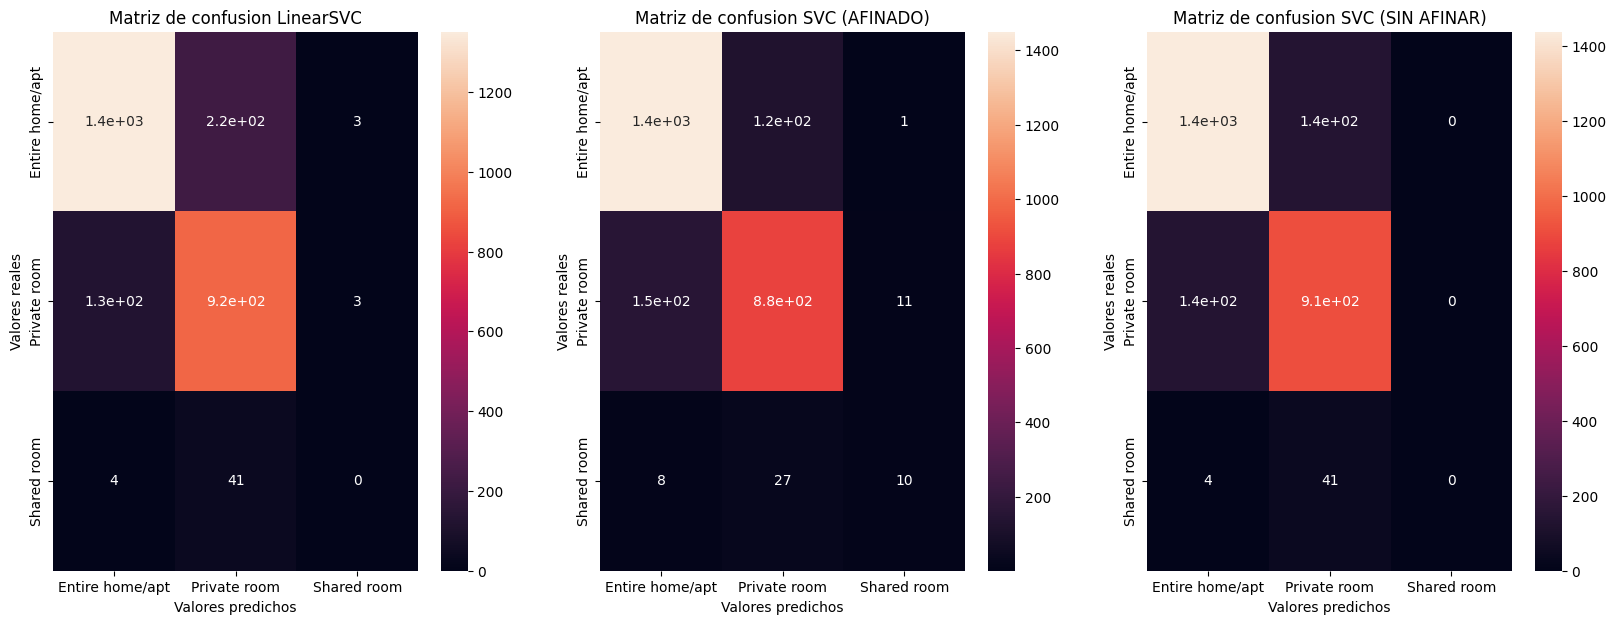

In [20]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(20,7))


# LinearSVC
# Predicción
y_prediction = linear_svc.predict(X_clf_test)

# Creamos la matriz de confusión
lin_svc_mat = confusion_matrix(y_clf_test, y_prediction)

# Visualizamos la matriz de confusión
sns.heatmap(lin_svc_mat, annot=True, ax=axes[0])
axes[0].title.set_text('Matriz de confusion LinearSVC')
axes[0].set(ylabel="Valores reales")
axes[0].set(xlabel="Valores predichos")
axes[0].xaxis.set_ticklabels(['Entire home/apt', 'Private room', 'Shared room']); 
axes[0].yaxis.set_ticklabels(['Entire home/apt', 'Private room', 'Shared room']);


# SVC AFINADO
svc = SVC(C=47.58383612588409, gamma=0.8408964152537145)
svc.fit(X_clf_train, y_clf_train)

# Predicción
y_prediction = svc.predict(X_clf_test)

# Creamos la matriz de confusión
svc_mat = confusion_matrix(y_clf_test, y_prediction)

# Visualizamos la matriz de confusión
sns.heatmap(svc_mat, annot=True, ax=axes[1])
axes[1].title.set_text('Matriz de confusion SVC (AFINADO)')
axes[1].set(ylabel="Valores reales")
axes[1].set(xlabel="Valores predichos")
axes[1].xaxis.set_ticklabels(['Entire home/apt', 'Private room', 'Shared room']); 
axes[1].yaxis.set_ticklabels(['Entire home/apt', 'Private room', 'Shared room']);


# SVC SIN AFINAR
svc = SVC()
svc.fit(X_clf_train, y_clf_train)

# Predicción
y_prediction = svc.predict(X_clf_test)

# Creamos la matriz de confusión
svc_mat = confusion_matrix(y_clf_test, y_prediction)

# Visualizamos la matriz de confusión
sns.heatmap(svc_mat, annot=True, ax=axes[2])
axes[2].title.set_text('Matriz de confusion SVC (SIN AFINAR)')
axes[2].set(ylabel="Valores reales")
axes[2].set(xlabel="Valores predichos")
axes[2].xaxis.set_ticklabels(['Entire home/apt', 'Private room', 'Shared room']); 
axes[2].yaxis.set_ticklabels(['Entire home/apt', 'Private room', 'Shared room']);


plt.show();

Como observamos en la imagen de arriba, el modelo SVC ya afinado obtiene mejores resultados, sobretodo a la hora de clasificar ```Shared room```, ya que en esta ocasión consigue al menos categorizar 10 instancias correctamente, cosa que no habían conseguido antes ninguno de los modelos. Por otro lado, vemos que consigue clasificar ligeramente mejor ```Private room``` y por el contrario, ha aumentado el número de instancias ```Entire home/apt``` clasificadas como ```Private room``` (erróneas). Sin embargo, en un cómputo general, el modelo ha obtenido mucho mejor resultado.

Ahora, pasaremos a la regresión.

C:\Users\Rafa\anaconda3\envs\mt_python\Lib\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
C:\Users\Rafa\anaconda3\envs\mt_python\Lib\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Rafa\anaconda3\envs\mt_python\Lib\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
C:\Users\Rafa\anaconda3\envs\mt_python\Lib\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
C:\Users\Rafa\anaconda3\envs\mt_python\Lib\site-packages\sklearn\sv

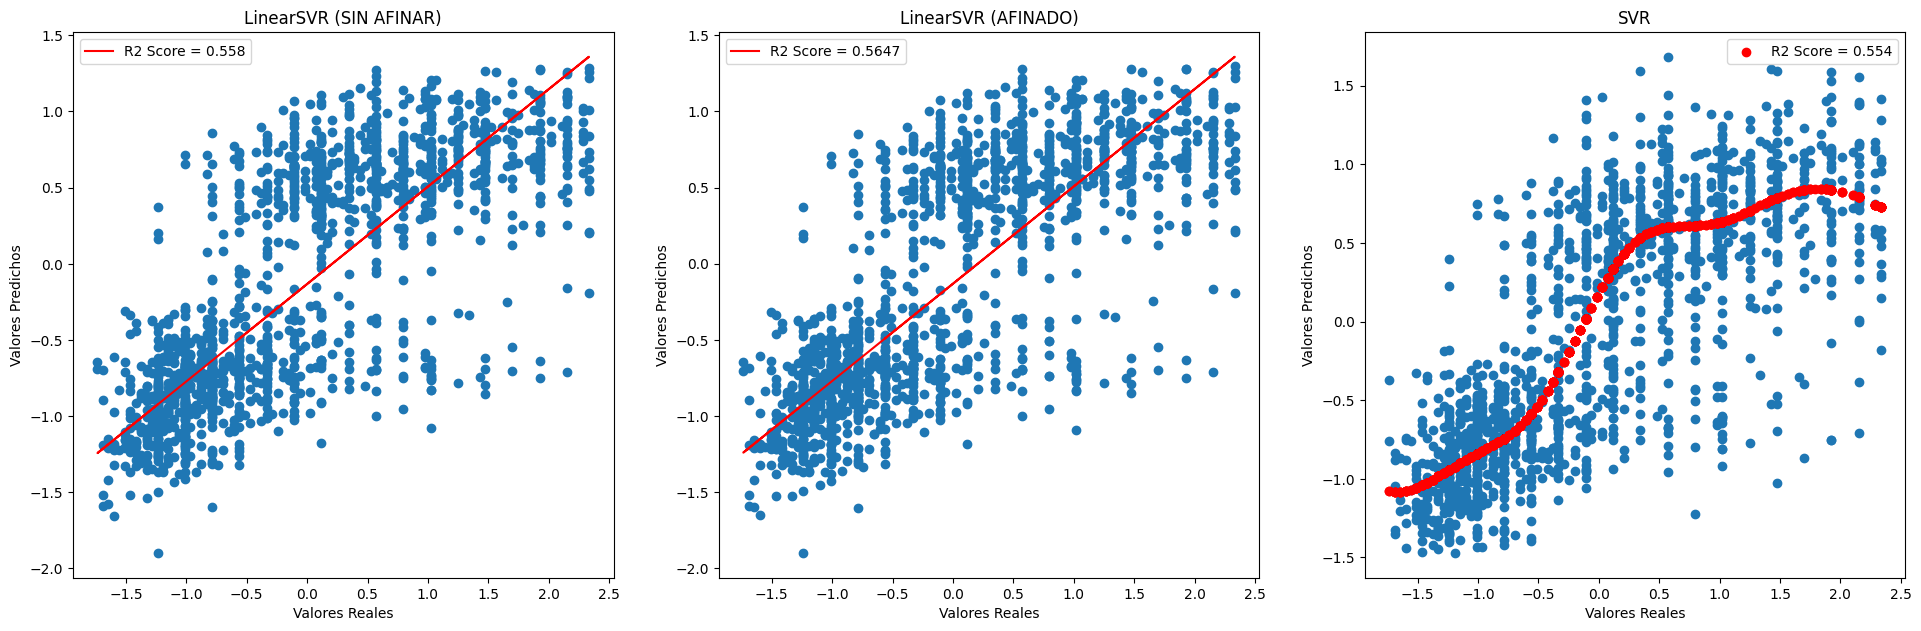

In [21]:
# Creamos una figura para dibujar nuestros gráficos
fig, axes = plt.subplots(ncols=3, figsize=(20, 7))
fig.tight_layout(pad=4.5)

# LinearSVR (SIN AFINAR)
linear_svr = LinearSVR()
linear_svr.fit(X_reg_train, y_reg_train)
y_predicted = linear_svr.predict(X_reg_test)

# Dibujamos los valores reales y predichos
axes[0].scatter(y_reg_test.values, y_predicted)

# Dibujamos la linea del R2 score
y_test = y_reg_test.values.reshape(-1,1)
axes[0].plot(y_test, 
             LinearSVR().fit(y_test, y_predicted).predict(y_test),
             color='r',
            label='R2 Score = 0.558')
axes[0].legend()



# Colocamos la etiqueta de los ejes
axes[0].set_xlabel('Valores Reales')
axes[0].set_ylabel('Valores Predichos')
axes[0].set_title('LinearSVR (SIN AFINAR)')
axes[0].legend()



# LinearSVR (AFINADO)
linear_svr = LinearSVR(C=1.131578947368421)
linear_svr.fit(X_reg_train, y_reg_train)
y_predicted = linear_svr.predict(X_reg_test)

# Dibujamos los valores reales y predichos
axes[1].scatter(y_reg_test.values, y_predicted)

# Dibujamos la linea del R2 score
y_test = y_reg_test.values.reshape(-1,1)
axes[1].plot(y_test, 
             LinearSVR(C=1.131578947368421).fit(y_test, y_predicted).predict(y_test),
             color='r',
            label='R2 Score = 0.5647')
axes[1].legend()



# Colocamos la etiqueta de los ejes
axes[1].set_xlabel('Valores Reales')
axes[1].set_ylabel('Valores Predichos')
axes[1].set_title('LinearSVR (AFINADO)')
axes[1].legend()


# SVR 
y_predicted = svr.predict(X_reg_test)

# Dibujamos los valores reales y predichos
axes[2].scatter(y_reg_test.values, y_predicted)

# Dibujamos la linea del R2 score
y_test = y_reg_test.values.reshape(-1,1)
axes[2].scatter(y_test,
             SVR().fit(y_test, y_predicted).predict(y_test),
            color='r',
            label='R2 Score = 0.554')

# Colocamos la etiqueta de los ejes
axes[2].set_xlabel('Valores Reales')
axes[2].set_ylabel('Valores Predichos')
axes[2].title.set_text('SVR')
axes[2].legend()



plt.show()

Como podemos observar en el gráfico, debido a que la mejora del modelo con la afinación ha sido ligeramente mejor, el modelo actúa de manera muy similar al anterior, aunque consigue mejores resultados. Esto se puede visualizar en la recta de ajuste (línea roja), donde podemos observar que el modelo cambia un poco su pendiente (poco perceptible).

En conclusión, esta actividad ha sido muy interesante para tratar con Máquinas de vectores de soporte (*Support Vector Machines*) y con la metodología de afinar hiperparámetros en modelos que pueden llevar un gran tiempo de ejecución.